# Spaceship Titanic

Predict which passengers are transported to an alternate dimension.

# Setup

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
all_df = [train, test]


def bprint(x):
    print(x)
    print("=" * 20)

# Preparing Data

## Exploration

In [145]:
for df in all_df:
    bprint(df.info())
    bprint(df.nunique())
    bprint(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP        

### Conclusions

- HomePlanet, Destination, VIP, and CryoSleep are categorical features.
- PassengerID, Cabin, and Name are qualitative.
- The rest is continuous.

## Analysing Continuous Features

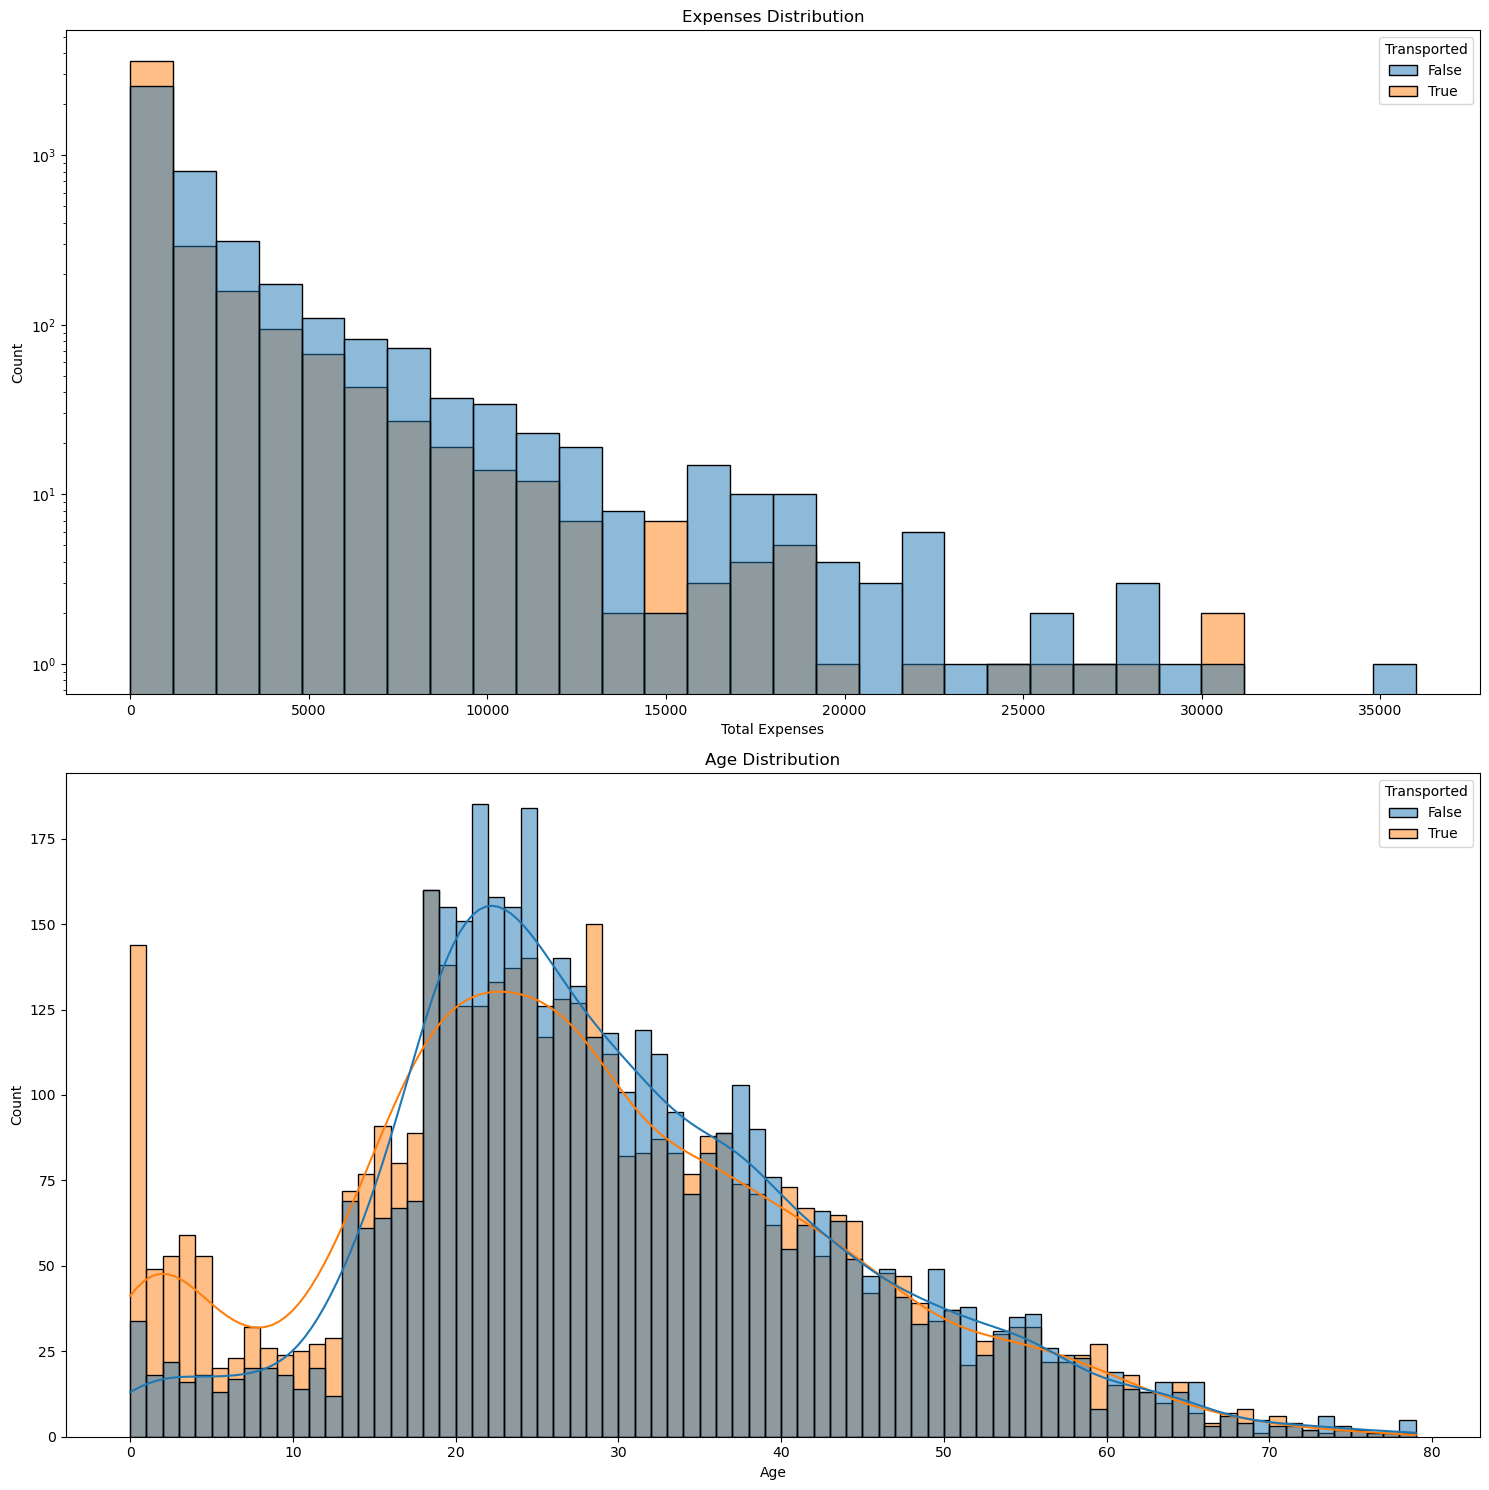

In [146]:
continuous_features = ["Age", "Expenses"]

# Combine all expenses into one column
expenses = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for df in all_df:
    df["Expenses"] = df[expenses].sum(axis=1)
    df.drop(expenses, axis=1, inplace=True)

# Plot continuous features
fig, axs = plt.subplots(nrows=len(continuous_features), figsize=(15, 15))

# Age
sns.histplot(data=train, x="Expenses", hue="Transported", bins=30, ax=axs[0])
axs[0].set_title("Expenses Distribution")
axs[0].set_xlabel("Total Expenses")
axs[0].set_yscale("log")

# Expenses
sns.histplot(data=train, x="Age", hue="Transported", binwidth=1, kde=True, ax=axs[1])
axs[1].set_title("Age Distribution")
axs[1].set_xlabel("Age")

plt.tight_layout()
plt.show()

### Conclusions

- Expenses do not seem to follow any particular pattern.
- Kids are very likely to be transported.
- Adults are likely to not be transported
- The chances are about evenly split for elders.

## Analysing Categorical Features

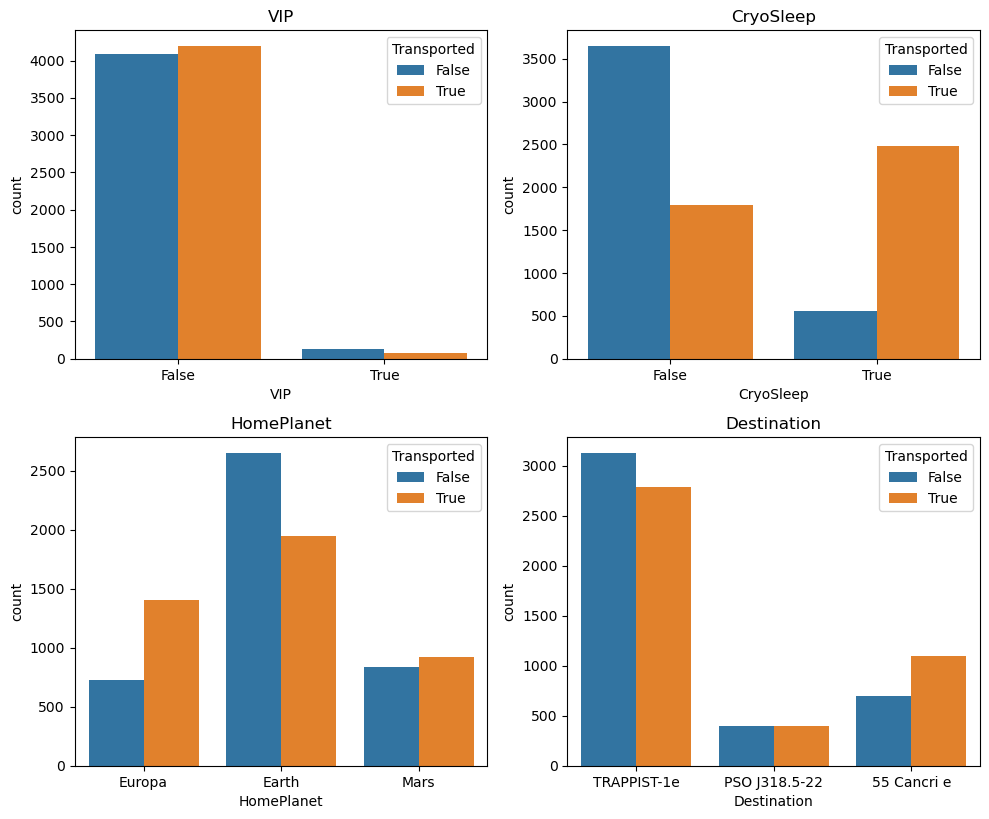

In [147]:
categorical_features = ["VIP", "CryoSleep", "HomePlanet", "Destination"]

fig = plt.figure(figsize=(10, 16))
for i, feature in enumerate(categorical_features):
    ax = fig.add_subplot(4, 2, i + 1)
    sns.countplot(data=train, x=feature, hue="Transported", axes=ax)
    ax.set_title(feature)
plt.tight_layout()
plt.show()

### Conclusions

- VIP seems to be irrelevant.
- Whether or not people where cryosleeping seems very important.

## Qualitative features

In [148]:
qualitative_features = ["PassengerId", "Cabin", "Name"]

print(train[qualitative_features].head(5))

  PassengerId  Cabin               Name
0     0001_01  B/0/P    Maham Ofracculy
1     0002_01  F/0/S       Juanna Vines
2     0003_01  A/0/S      Altark Susent
3     0003_02  A/0/S       Solam Susent
4     0004_01  F/1/S  Willy Santantines


### Conclusions

- PassengerId can be used to gather informations about the passenger's group.
- Cabin can help us pinpoint the location of the passenger on the ship.
- Name can help grouping passengers by families, but it doesn't seem that useful.

# Modeling Data

Using the conclusions drawn above, we can improve our set of features.

## Age

In [149]:
# Are there any missing values?
for df in all_df:
    bprint(df["Age"].isna().sum())

179
91


Text(0.5, 1.0, 'Age Group Distribution')

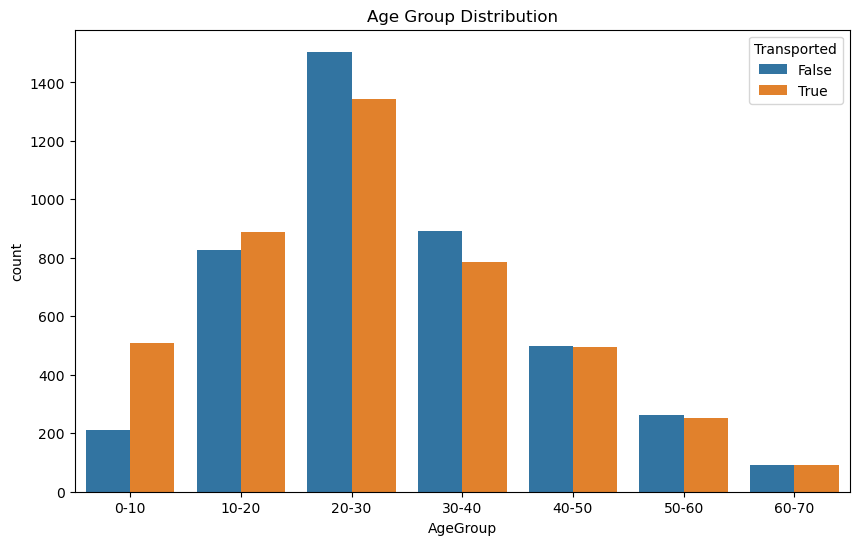

In [150]:
# Fill missing values with the median
for df in all_df:
    df["Age"].fillna(df["Age"].median(), inplace=True)

for df in all_df:
    age_bins = range(0, int(df["Age"].max()), 10)
    groups = [f"{i}-{i+10}" for i in age_bins[:-1]]
    df["AgeGroup"] = pd.cut(
        df["Age"], bins=age_bins, labels=groups, include_lowest=True
    )
    df.drop("Age", axis=1, inplace=True)

plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="AgeGroup", hue="Transported")
plt.title("Age Group Distribution")

## Expenses

0    False
1     True
2     True
3     True
4     True
Name: SpentMoney, dtype: bool


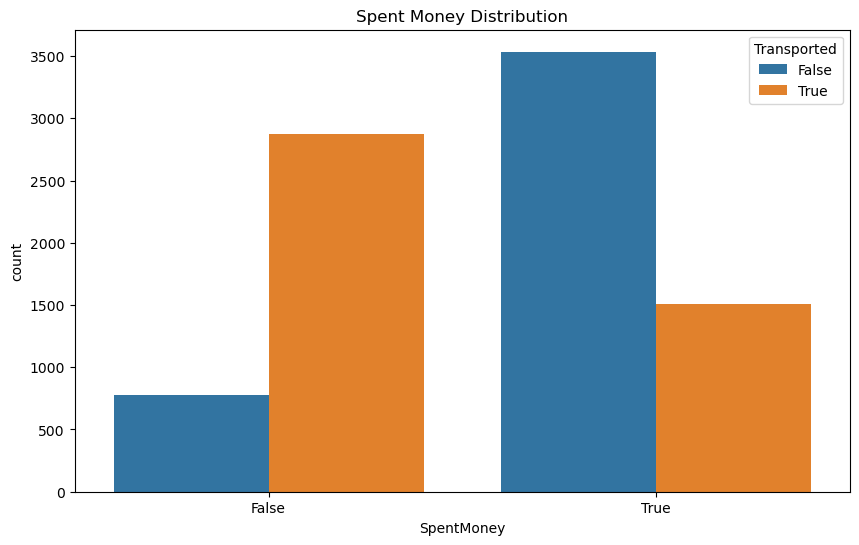

In [151]:
# Create a binary feature
for df in all_df:
    df["SpentMoney"] = df.apply(lambda x: x["Expenses"] > 0, axis=1)
    df.drop("Expenses", axis=1, inplace=True)

print(train["SpentMoney"].head(5))

plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="SpentMoney", hue="Transported")
plt.title("Spent Money Distribution")
plt.show()

## PassengerId

  PassengerId Group  GroupSize
0     0001_01  0001          1
1     0002_01  0002          1
2     0003_01  0003          2
3     0003_02  0003          2
4     0004_01  0004          1


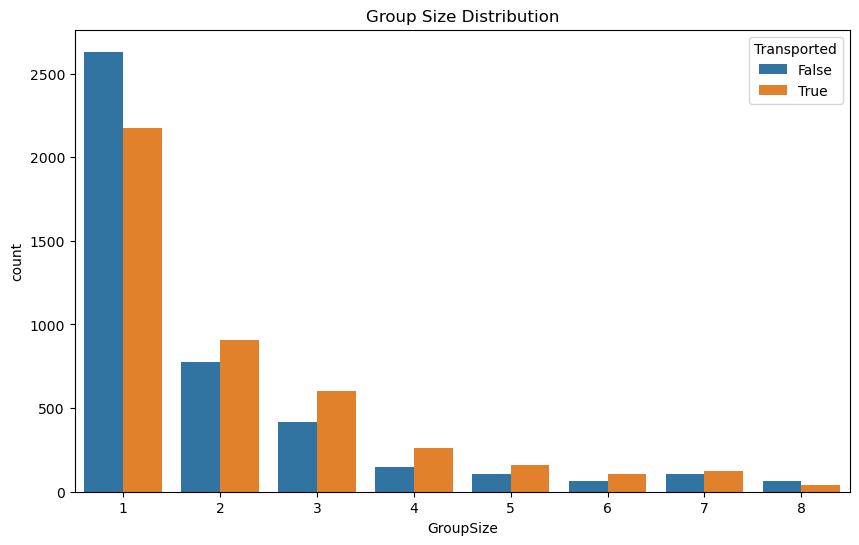

In [152]:
passenger_group_features = ["Group", "GroupSize"]

# Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
for df in all_df:
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["GroupSize"] = df["Group"].map(df["Group"].value_counts())

bprint(train.head(5)[["PassengerId", *passenger_group_features]])

plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="GroupSize", hue="Transported")
plt.title("Group Size Distribution")
plt.show()

**Travelling alone seems to give higher chance of not being transported, let's create a binary feature describing whether or not the passenger is alone.**

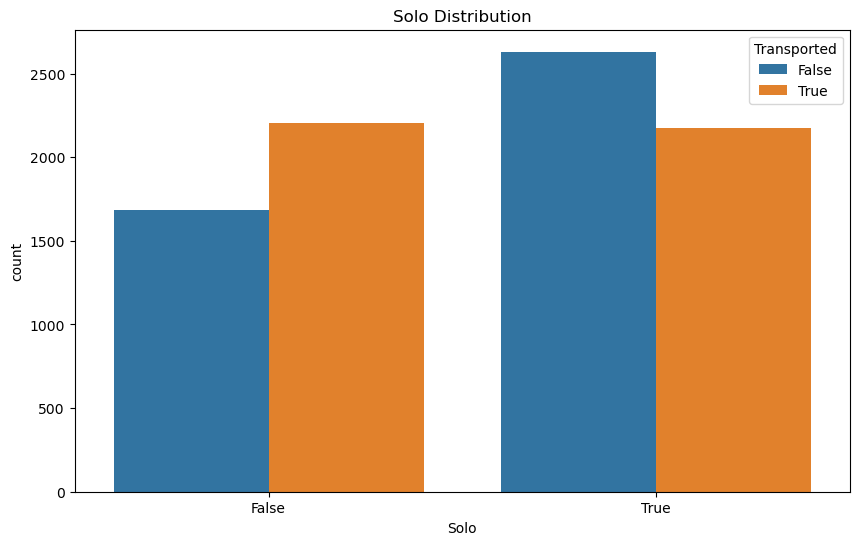

In [153]:
for df in all_df:
    df["Solo"] = df["GroupSize"].apply(lambda x: x == 1)
    df.drop("GroupSize", axis=1, inplace=True)

# Plot the solo feature
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="Solo", hue="Transported")
plt.title("Solo Distribution")
plt.show()

## Cabin

In [154]:
location_features = ["CabinDeck", "CabinSide"]

for df in all_df:
    df["CabinDeck"] = df["Cabin"].apply(lambda x: x[0] if pd.notna(x) else x)
    df["CabinSide"] = df["Cabin"].apply(lambda x: x[-1] if pd.notna(x) else x)

print(train.head(5)[["Cabin", *location_features]])

# Drop the Cabin feature
for df in all_df:
    df.drop("Cabin", axis=1, inplace=True)

   Cabin CabinDeck CabinSide
0  B/0/P         B         P
1  F/0/S         F         S
2  A/0/S         A         S
3  A/0/S         A         S
4  F/1/S         F         S


In [155]:
# Some are still missing, so we'll fill them with the mode.
bprint(train[location_features].isna().sum())

for feature in location_features:
    train[feature].fillna(train[feature].mode()[0], inplace=True)
bprint(train[location_features].isna().sum())

CabinDeck    199
CabinSide    199
dtype: int64
CabinDeck    0
CabinSide    0
dtype: int64


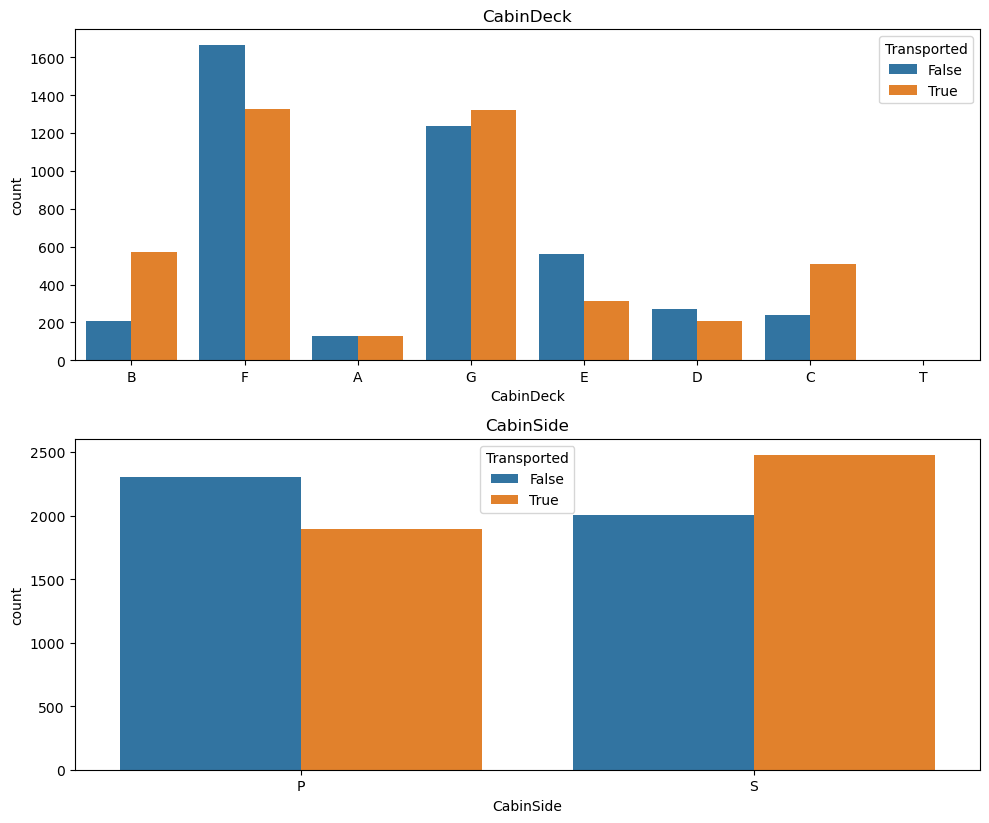

In [156]:
# Plot distribution of new features
fig = plt.figure(figsize=(10, 12))
for i, feature in enumerate(location_features):
    ax = fig.add_subplot(3, 1, i + 1)
    sns.countplot(data=train, x=feature, hue="Transported", ax=ax)
    ax.set_title(feature)

fig.tight_layout()

## CryoSleep

We can easily conclude that any passenger that has spent some money during the trip was not cryosleeping. Using that knowledge we can fill some of the empty values.

217
93
0
0


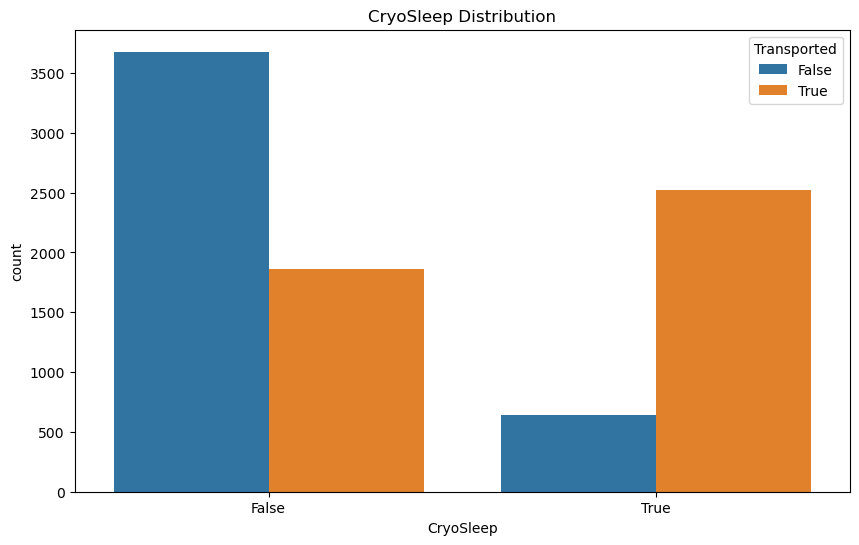

In [157]:
for df in all_df:
    bprint(df["CryoSleep"].isna().sum())

# Fill missing values with true if they have SpentMoney, false otherwise
for df in all_df:
    df["CryoSleep"].fillna(df["SpentMoney"], inplace=True)

for df in all_df:
    bprint(df["CryoSleep"].isna().sum())

# Plot distribution of cryosleep
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="CryoSleep", hue="Transported")
plt.title("CryoSleep Distribution")
plt.show()

## HomePlanet

201
87


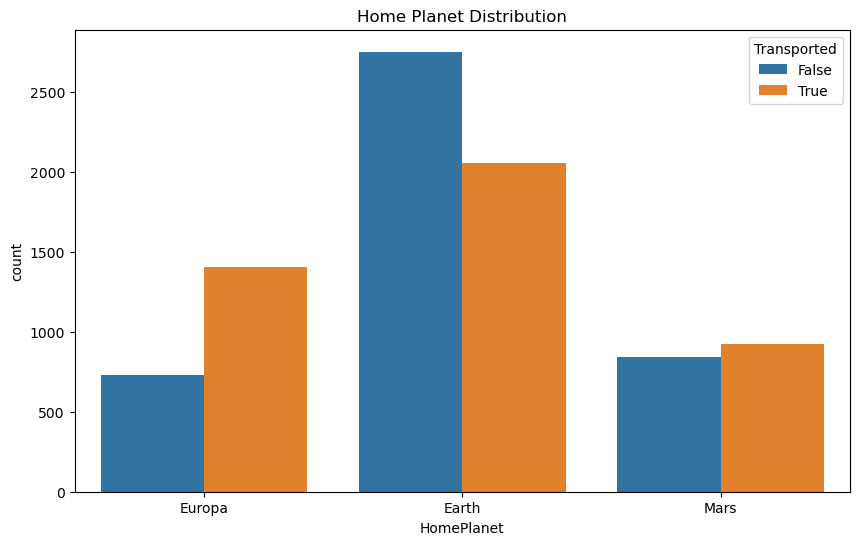

In [158]:
for df in all_df:
    bprint(df["HomePlanet"].isna().sum())
    # Fill missing values with the mode
    df["HomePlanet"].fillna(df["HomePlanet"].mode()[0], inplace=True)

plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="HomePlanet", hue="Transported")
plt.title("Home Planet Distribution")
plt.show()

## Destination

182
92


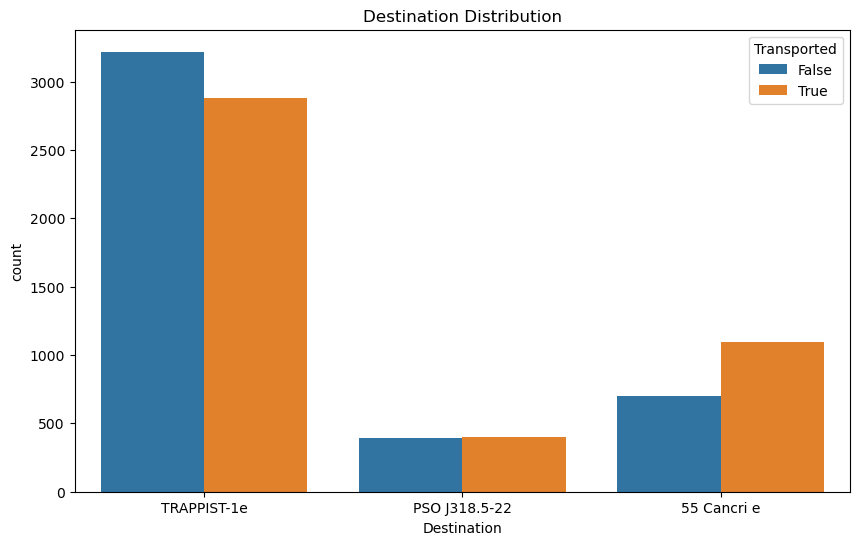

In [159]:
for df in all_df:
    bprint(df["Destination"].isna().sum())
    # Fill missing values with the mode
    df["Destination"].fillna(df["Destination"].mode()[0], inplace=True)

plt.figure(figsize=(10, 6))
sns.countplot(data=train, x="Destination", hue="Transported")
plt.title("Destination Distribution")
plt.show()


## Hot-Enconding

In [160]:
label = LabelEncoder()
for df in all_df:
    df["CabinDeck"] = label.fit_transform(df["CabinDeck"])
    df["CabinSide"] = label.fit_transform(df["CabinSide"])
    df["Destination"] = label.fit_transform(df["Destination"])
    df["HomePlanet"] = label.fit_transform(df["HomePlanet"])
    df["AgeGroup"] = label.fit_transform(df["AgeGroup"])

## Deleting Useless Features

In [161]:
for df in all_df:
    df.drop("Name", axis=1, inplace=True)
    df.drop("VIP", axis=1, inplace=True)

print(train.head(5))

  PassengerId  HomePlanet  CryoSleep  Destination  Transported  AgeGroup  \
0     0001_01           1      False            2        False         3   
1     0002_01           0      False            2         True         2   
2     0003_01           1      False            2        False         5   
3     0003_02           1      False            2        False         3   
4     0004_01           0      False            2         True         1   

   SpentMoney Group   Solo  CabinDeck  CabinSide  
0       False  0001   True          1          0  
1        True  0002   True          5          1  
2        True  0003  False          0          1  
3        True  0003  False          0          1  
4        True  0004   True          5          1  


# Predicting 

## Create Model

In [162]:
target = ["Transported"]
features = [col for col in train.columns if col not in ["PassengerId", "Transported"]]

y = train[target]
train_X = train[features]
test_X = test[features]

In [163]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(train_X, y)

C:\Users\masme\AppData\Local\Temp\ipykernel_10456\1326535565.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, y)


RandomForestClassifier(max_depth=5, random_state=1)

## Predict outcomes

In [164]:
predictions = model.predict(test_X)

## Create submission.csv

In [165]:
submission = pd.DataFrame(
    {"PassengerId": test["PassengerId"], "Transported": predictions}
)
submission.to_csv("submission.csv", index=False)